In [700]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import sys
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

In [2]:
!pip3 install --user opencv-python==3.4.2.16
!pip3 install --user opencv-contrib-python==3.4.2.16

  Using cached https://files.pythonhosted.org/packages/fa/7d/5042b668a8ed41d2a80b8c172f5efcd572e3c046c75ae029407e19b7fc68/opencv_python-3.4.2.16-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/03/27/e35e7c6e6a52fab9fcc64fc2b20c6b516eba930bb02b10ace3b38200d3ab/numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/08/f1/66330f4042c4fb3b2d77a159db8e8916d9cdecc29bc8c1f56bc7f8a9bec9/opencv_contrib_python-3.4.2.16-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/03/27/e35e7c6e6a52fab9fcc64fc2b20c6b516eba930bb02b10ace3b38200d3ab/numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl


In [702]:
sift = cv2.xfeatures2d.SIFT_create()


In [701]:
# Provided Functions

def compute_camera_pose(F, K):
    E = K.T @ F @ K
    R_1, R_2, t = cv2.decomposeEssentialMat(E)
    # 4 cases
    R1, t1 = R_1, t
    R2, t2 = R_1, -t
    R3, t3 = R_2, t
    R4, t4 = R_2, -t

    Rs = [R1, R2, R3, R4]
    ts = [t1, t2, t3, t4]
    Cs = []
    for i in range(4):
        Cs.append(-Rs[i].T @ ts[i])
    return Rs, Cs


def visualize_img_pair(img1, img2):
    img = np.hstack((img1, img2))
    if img1.ndim == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


def visualize_find_match(img1, img2, pts1, pts2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    img_h = img1.shape[0]
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    pts1 = pts1 * scale_factor1
    pts2 = pts2 * scale_factor2
    pts2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for i in range(pts1.shape[0]):
        plt.plot([pts1[i, 0], pts2[i, 0]], [pts1[i, 1], pts2[i, 1]], 'b.-', linewidth=0.5, markersize=5)
    plt.axis('off')
    plt.show()


def visualize_epipolar_lines(F, pts1, pts2, img1, img2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    for i in range(pts1.shape[0]):
        x1, y1 = int(pts1[i][0] + 0.5), int(pts1[i][1] + 0.5)
        ax1.scatter(x1, y1, s=5)
        p1, p2 = find_epipolar_line_end_points(img2, F, (x1, y1))
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    for i in range(pts2.shape[0]):
        x2, y2 = int(pts2[i][0] + 0.5), int(pts2[i][1] + 0.5)
        ax2.scatter(x2, y2, s=5)
        p1, p2 = find_epipolar_line_end_points(img1, F.T, (x2, y2))
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    ax1.axis('off')
    ax2.axis('off')
    plt.show()


def find_epipolar_line_end_points(img, F, p):
    img_width = img.shape[1]
    el = np.dot(F, np.array([p[0], p[1], 1]).reshape(3, 1))
    p1, p2 = (0, -el[2] / el[1]), (img.shape[1], (-img_width * el[0] - el[2]) / el[1])
    _, p1, p2 = cv2.clipLine((0, 0, img.shape[1], img.shape[0]), p1, p2)
    return p1, p2


def visualize_camera_poses(Rs, Cs):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2 = Rs[i], Cs[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1)
        draw_camera(ax, R2, C2)
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()


def visualize_camera_poses_with_pts(Rs, Cs, pts3Ds):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2, pts3D = Rs[i], Cs[i], pts3Ds[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1, 5)
        draw_camera(ax, R2, C2, 5)
        ax.plot(pts3D[:, 0], pts3D[:, 1], pts3D[:, 2], 'b.')
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()


def draw_camera(ax, R, C, scale=0.2):
    axis_end_points = C + scale * R.T  # (3, 3)
    vertices = C + scale * R.T @ np.array([[1, 1, 1], [-1, 1, 1], [-1, -1, 1], [1, -1, 1]]).T  # (3, 4)
    vertices_ = np.hstack((vertices, vertices[:, :1]))  # (3, 5)

    # draw coordinate system of camera
    ax.plot([C[0], axis_end_points[0, 0]], [C[1], axis_end_points[1, 0]], [C[2], axis_end_points[2, 0]], 'r-')
    ax.plot([C[0], axis_end_points[0, 1]], [C[1], axis_end_points[1, 1]], [C[2], axis_end_points[2, 1]], 'g-')
    ax.plot([C[0], axis_end_points[0, 2]], [C[1], axis_end_points[1, 2]], [C[2], axis_end_points[2, 2]], 'b-')

    # draw square window and lines connecting it to camera center
    ax.plot(vertices_[0, :], vertices_[1, :], vertices_[2, :], 'k-')
    ax.plot([C[0], vertices[0, 0]], [C[1], vertices[1, 0]], [C[2], vertices[2, 0]], 'k-')
    ax.plot([C[0], vertices[0, 1]], [C[1], vertices[1, 1]], [C[2], vertices[2, 1]], 'k-')
    ax.plot([C[0], vertices[0, 2]], [C[1], vertices[1, 2]], [C[2], vertices[2, 2]], 'k-')
    ax.plot([C[0], vertices[0, 3]], [C[1], vertices[1, 3]], [C[2], vertices[2, 3]], 'k-')


def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
    y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
    z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def visualize_disparity_map(disparity):
    plt.imshow(disparity, cmap='jet')
    plt.show()

In [703]:
def find_match(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1,des1 = sift.detectAndCompute(img1,None)
    kp2,des2 = sift.detectAndCompute(img2,None)
    
    points1 = cv2.KeyPoint_convert(kp1)
    points2 = cv2.KeyPoint_convert(kp2)
    
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(des1)
    distances, indices = nbrs.kneighbors(des2)
    #so each index of distances is a list of the closest distances to that index of the keypoints
    temp1 = []
    temp2 = []
    for i in range(len(distances)):
        for j in range(1, len(distances[i])):
            if distances[i][0] < .7*distances[i][j]:
                temp2.append(points2[i])
                temp1.append(points1[indices[i,0]])  
    
    temp1 = np.asarray(temp1)
    temp2 = np.asarray(temp2)

    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(des2)
    distances, indices = nbrs.kneighbors(des1)
    x1 = []
    x2 = [] 
    for i in range(len(distances)):
        for j in range(1, len(distances[i])):
            if distances[i][0] < .7*distances[i][j]:
                if points1[i] in temp1:
                    x2.append(points2[indices[i,0]])
                    x1.append(points1[i])

    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    return x1, x2

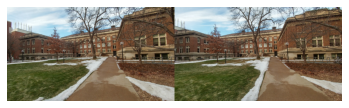

In [618]:
img2 = cv2.imread('left.bmp')
img1 = cv2.imread('right.bmp')

visualize_img_pair(img1, img2)


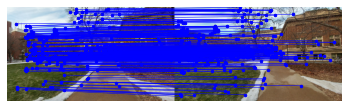

In [619]:
x1, x2 = find_match(img1, img2)
visualize_find_match(img1, img2, x1, x2)

In [704]:
import random
def compute_F(pts1, pts2):
    ransac_iter = 10000
    best_F = np.zeros(shape = (3,3))
    curloss = np.inf

    for i in range(ransac_iter):
        indices = random.sample(range(0, pts1.shape[0]), 8)
        for i in range(8):
            ux, uy = pts1[indices[i]]
            vx, vy = pts2[indices[i]]
            row = np.array([
                ux*vx,
                uy*vx,
                vx,
                ux*vy,
                uy*vy,
                vy,
                ux,
                uy,
                1
            ])
            A[i, :] = row.reshape((1,9))
        
        f = null_space(A)
        try:
            F = f.reshape(3,3)

            
            loss = 0
            for i in range(pts1.shape[0]):
                vx, vy = pts2[i]
                ux, uy = pts1[i]
                loss += np.linalg.norm(np.array([vx, vy, 1]) @ F @ np.array([ux, uy, 1]).T)

            if loss < curloss:
                curloss = loss
#                 print(curloss)
                best_F = F

        except:
            continue    
    U, s, vh = np.linalg.svd(best_F)
    s[2] = 0
    best_F = np.matmul(U * s, vh)
    return best_F

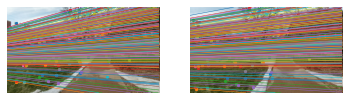

In [620]:
F = compute_F(x1, x2)

visualize_epipolar_lines(F, x1, x2, img1, img2)

In [274]:
cur_best_F = F

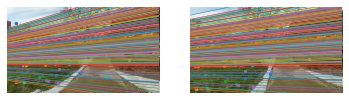

In [275]:
visualize_epipolar_lines(cur_best_F, x1, x2, img1, img2)

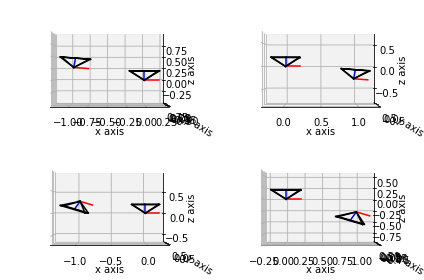

In [621]:
K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
Rs, Cs = compute_camera_pose(F, K)
visualize_camera_poses(Rs, Cs)

In [622]:
pts1 = x1
pts2 = x2

In [705]:
def triangulation(P1, P2, pts1, pts2):
    # TO DO
    pts3D = []
    
    for i in range(pts1.shape[0]):
        ux, uy = pts1[i]
        vx, vy = pts2[i]
        
        skew_u = np.array([
            [0, -1, uy],
            [1, 0, -ux],
            [-uy, ux, 0]
        ])
        
        skew_v = np.array([
            [0, -1, vy],
            [1, 0, -vx],
            [-vy, vx, 0]
        ])
        
        comb_1 = skew_u @ P1
        comb_2 = skew_v @ P2
        
        final = np.append(comb_1, comb_2, axis = 0)
        x, residuals, rank, s = np.linalg.lstsq(final[:,:3], -final[:,3], rcond=-1)
        pts3D.append(x)

    pts3D = np.array(pts3D)
    print(np.mean(pts3D))
    
    print(pts3D.shape)
        
    return pts3D

4.341128056835033
(318, 3)
-4.341128056835033
(318, 3)
-0.04404755956234103
(318, 3)
0.04404755956234103
(318, 3)


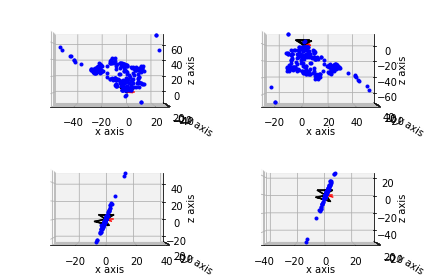

In [623]:
pts3Ds = []
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
for i in range(len(Rs)):
    P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
    pts3D = triangulation(P1, P2, pts1, pts2)
    pts3Ds.append(pts3D)
visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

In [706]:
def disambiguate_pose(Rs, Cs, pts3Ds):
    # TO DO
    # points must be in front of both cameras
    tot_in = -np.inf
    
    for i in range(len(Rs)):
        num_in = 0
        r3t = (Rs[i][2]).reshape(1,3)
        cam2_3T = np.eye(3)
        cam2 = np.zeros((3,1))
        X = pts3Ds[i].T
        C = Cs[i]
        num_in = np.sum(((r3t @ (X - C)) > 0) & (cam2_3T @ (X-cam2)>0))
#         print(num_in)
        if num_in > tot_in:
            tot_in = num_in
            R = Rs[i]
            C = Cs[i]
            pts3D = pts3Ds[i]
#             print(i)
    
    return R, C, pts3D

In [624]:
# Step 5: disambiguate camera poses
R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

In [707]:
def compute_rectification(K, R, C):
    rx = C/np.linalg.norm(C)
    rz_hat = np.array([[0,0,1]]).T
    
    temp = rz_hat - np.sum(rx*rz_hat)*rx
    rz = temp/np.linalg.norm(temp)
    
    ry = np.cross(rz, rx, axisa=0, axisb=0)
    print(ry.shape)
    
    r_rect = np.zeros((1, ry.shape[1]))
    
    r_rect = np.append(r_rect, rx.T, axis=0)
    r_rect = np.append(r_rect, ry, axis=0)
    r_rect = np.append(r_rect, rz.T, axis=0)
    r_rect = r_rect[1:, :]
    
    K_inv = np.linalg.inv(K)

    H1 = K @ r_rect @ K_inv
    H2 = K @ r_rect @ R.T @ K_inv

    return H1, H2

(1, 3)


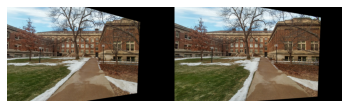

In [663]:
H1, H2 = compute_rectification(K, R, C)
img_left = img1
img_right = img2
img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
visualize_img_pair(img_left_w, img_right_w)

In [722]:
def dense_match(img2, img1):
    sift = cv2.xfeatures2d.SIFT_create()
    h, w = img1.shape
    
    disparity = np.zeros((h, w))
    
    keypoints = np.array([cv2.KeyPoint(x, y, 2) 
                                   for y in range(0, img1.shape[0], 1) 
                                    for x in range(0, img1.shape[1], 1)])
    
    img1_f = sift.compute(img1, keypoints)[1]
    img2_f = sift.compute(img2, keypoints)[1]
    
    print("finished keypoints")
    
    for i in range(h):
#         nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(img1_f[i*w:(i+1)*w])
#         dist, index = nbrs.kneighbors(img2_f[i*w:(i+1)*w])
        if i % 50 == 0:
            print(i)
        for j in range(w):
#             if dist[j] == 0:
#                 disparity[i,j] = 0
#             else:
#                 disparity[i,j] = np.abs(j - index[j])
            df_1 = img1_f[i*w+j]
            min_d = np.inf
            min_index = -1
            for k in range(j, w):
                df_2 = img2_f[i*w+k]
                d = np.linalg.norm(df_1 - df_2)
                if d < min_d:
                    min_d = d
                    min_index = k-j
                if d == 0:
                    min_index = 0
            disparity[i, j] = min_index

    # TO DO
    return disparity


finished keypoints
0
50
100
150
200
250


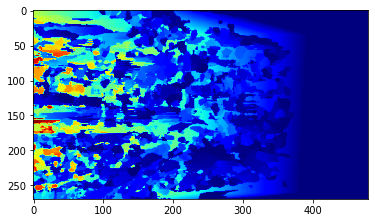

In [719]:
img_left = img1
img_right = img2
img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))
img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)
disparity = dense_match(img_left_w, img_right_w)
visualize_disparity_map(disparity)

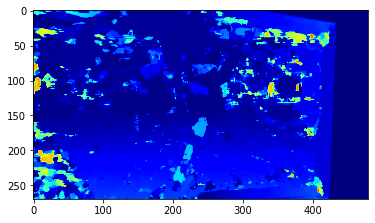

In [710]:
# kinda_good_disparity = disparity
take_2_disparity = disparity
visualize_disparity_map(kinda_good_disparity)

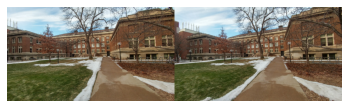

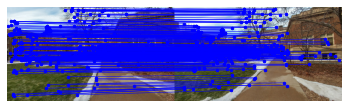

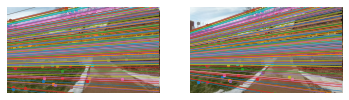

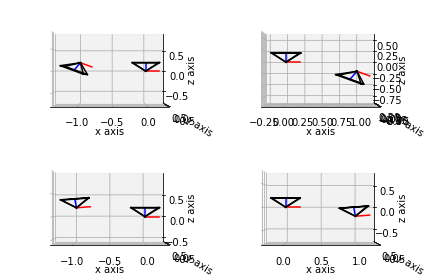

-0.4507311656430483
(317, 3)
0.4507311656430483
(317, 3)
-3.4334550852786476
(317, 3)
3.4334550852786476
(317, 3)


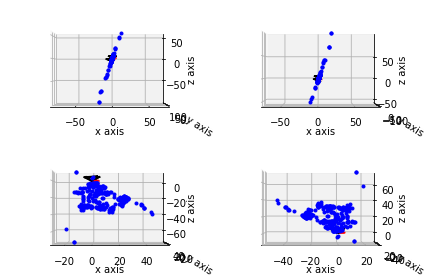

(1, 3)


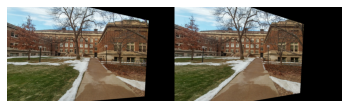

finished keypoints
0
50
100
150
200
250


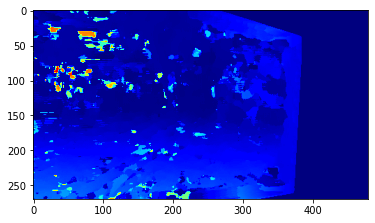

In [723]:
if __name__ == '__main__':
    # read in left and right images as RGB images
    img_left = cv2.imread('./left.bmp', 1)
    img_right = cv2.imread('./right.bmp', 1)
    visualize_img_pair(img_left, img_right)

    # Step 1: find correspondences between image pair
    pts1, pts2 = find_match(img_left, img_right)
    visualize_find_match(img_left, img_right, pts1, pts2)

    # Step 2: compute fundamental matrix
    F = compute_F(pts1, pts2)
    visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

    # Step 3: computes four sets of camera poses
    K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
    Rs, Cs = compute_camera_pose(F, K)
    visualize_camera_poses(Rs, Cs)

    # Step 4: triangulation
    pts3Ds = []
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(len(Rs)):
        P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
        pts3D = triangulation(P1, P2, pts1, pts2)
        pts3Ds.append(pts3D)
    visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

    # Step 5: disambiguate camera poses
    R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

    # Step 6: rectification
    H1, H2 = compute_rectification(K, R, C)
    img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
    img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
    visualize_img_pair(img_left_w, img_right_w)

    # Step 7: generate disparity map
    img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
    img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))
    img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
    img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)
    disparity = dense_match(img_left_w, img_right_w)
    visualize_disparity_map(disparity)

    # save to mat
    sio.savemat('stereo.mat', mdict={'pts1': pts1, 'pts2': pts2, 'F': F, 'pts3D': pts3D, 'H1': H1, 'H2': H2,
                                     'img_left_w': img_left_w, 'img_right_w': img_right_w, 'disparity': disparity})
